In [1]:
import re
import numpy as np
import os
import pandas as pd
import gensim.downloader
from gensim.models import KeyedVectors, Word2Vec
import torch.nn.functional as F
from tqdm import tqdm
import random
# keras-tf 2.0
# from tensorflow import set_random_seed
from tensorflow.keras import backend as K
from tensorflow.keras.utils import set_random_seed
from keras import layers, initializers, regularizers, constraints
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPooling1D, Concatenate, Layer, GlobalAveragePooling1D, concatenate
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
import gc
# from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from keras.initializers import *
from keras.optimizers import *
from keras.callbacks import *
import tensorflow as tf
# from keras_self_attention import SeqSelfAttention
import nlpaug.augmenter.word as naw
# from nlpaug.util.file.download import DownloadUtil
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
import contractions
from gensim.parsing.preprocessing import strip_punctuation, strip_tags
import inflect
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
tqdm.pandas(desc='Progress')

In [2]:
train_df = pd.read_csv('./TREC/train.csv')
test_df = pd.read_csv('./TREC/test.csv')

## Basic Params

In [3]:
embed_size = 300 # how big is each word vector
max_features = 3000001 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 60 # max number of words in a question to use


## Preprocessing

Dropping the "label-fine" columns as we just looking at "label-coarse"

In [4]:
train_df.drop(['label-fine'], axis=1, inplace=True)
test_df.drop(['label-fine'], axis=1, inplace=True)

In [5]:
# Print the number of samples in train and test set
print(f"The number of samples in train and test set: {len(train_df), len(test_df)}")

The number of samples in train and test set: (5452, 500)


In [6]:
# Set seed for reproducibility
SEED=11

# function to seed everything
def seed_everything(seed=SEED):
    np.random.seed(seed)
    # os.environ['PYTHONHASHSEED'] = str(seed)
    # set_random_seed(seed)
    # random.seed(seed)

# Seed everything
seed_everything()

# Specify the number of values to randomly select
num_values_to_select = 4

# Get unique values from the 'labels' column
unique_labels = train_df['label-coarse'].unique()

# Use numpy's random.choice to randomly select unique values
classes_to_keep = np.random.choice(unique_labels, num_values_to_select, replace=False)

# Keep only the rows with selected values
train_filtered_df = train_df[train_df['label-coarse'].isin(classes_to_keep)]

# Get the rows with labels not in the selected values
filtered_df = train_df[~train_df['label-coarse'].isin(classes_to_keep)]

# Change all values in the 'labels' column of the filtered DataFrame to 'OTHERS' or we use 7 to represent this
filtered_df.loc[:, 'label-coarse'] = 7

# Merge (join) filtered_df with df2 on index
final_train_df = pd.concat([train_filtered_df, filtered_df], axis=0, ignore_index=True)

# Shuffle the rows
shuffled_final_df = final_train_df.sample(frac=1).reset_index(drop=True)

print(f"5 Classes: {shuffled_final_df['label-coarse'].value_counts()}")  

5 Classes: label-coarse
7    2412
3    1223
4     896
5     835
2      86
Name: count, dtype: int64


In [7]:
# do it for test set too

# Define a custom function to apply
def replace_values(value):
    return value if value in classes_to_keep else 7

# Apply the function to each element in the DataFrame
test_df['label-coarse'] = test_df['label-coarse'].apply(replace_values)

test_df.head(20)

,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,5,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,7,What is an atom ?
4,4,When did Hawaii become a state ?
5,4,How tall is the Sears Building ?
6,3,George Bush purchased a small interest in whic...
7,7,What is Australia 's national flower ?
8,7,Why does the moon turn orange ?
9,7,What is autism ?


## Getting the Development Set

In [8]:
# Randomly sample 500 rows
dev_df = shuffled_final_df.sample(n=500, random_state=SEED)

# Remove the sampled rows from shuffled_df
shuffled_train_df = shuffled_final_df.drop(dev_df.index)

# Reset index for both dataframes
dev_df.reset_index(drop=True, inplace=True)
shuffled_train_df.reset_index(drop=True, inplace=True)

# Print the sampled and updated shuffled dataframes
print("Dev DataFrame:")
print(dev_df)

print("\nUpdated Training DataFrame:")
print(shuffled_train_df.iloc[1])

Dev DataFrame:
     label-coarse                                               text
0               7                                  What are values ?
1               7                  What is `` the bear of beers '' ?
2               7                      What color are school buses ?
3               5                 What country is Mount Everest in ?
4               7                      What is the function of RAM ?
..            ...                                                ...
495             7                        What does laser stand for ?
496             3                               Who were the Picts ?
497             5                    What is worth seeing in Reims ?
498             5    What U.S. state borders Illinois to the north ?
499             3  What was the name of Randy Steven Craft 's law...

[500 rows x 2 columns]

Updated Training DataFrame:
label-coarse                                                    4
text            The Shea & Gould law f

In [9]:
# Get the word2vec embeddings for the words in our vocabulary
if os.path.exists('data/word2vec-google-news-300.bin'):
    word2vecs_embeddings = KeyedVectors.load('data/word2vec-google-news-300.bin')
else:
    word2vecs_embeddings = gensim.downloader.load('word2vec-google-news-300')
    word2vecs_embeddings.save('data/word2vec-google-news-300.bin')

In [10]:
word_to_ix = word2vecs_embeddings.key_to_index

## Perform Regex

In [11]:
# getting the corpus
corpus = shuffled_train_df['text'].tolist()

# Remove chars that are not letters or numbers
def clean_text(val):
    # Define a regular expression pattern for punctuations
    punctuation_pattern = re.compile(r'[^\w\s#,.-]')

    # Use re.sub to replace punctuations with nothing
    text_without_punctuation = punctuation_pattern.sub('', val)

    # Replace hyphens with a space
    text_without_punctuation = text_without_punctuation.replace('-', ' ')

    # Replace commas in numbers
    x = re.sub(r'(?<=\d),(?=\d)', '', text_without_punctuation)
    
    # # Remove stop words
    # sentence = [word for word in sentence.split() if word.lower() not in STOP_WORDS]
    # sentence = " ".join(sentence)
    return x

def remove_single_letters(sentence):
    # Use regular expression to remove spaces after single characters (except 'a' and 'I')
    for word in sentence.split():
        if word.lower() == "s":
            word = word.replace("s", "is")
    cleaned_text = re.sub(r'(?<![aI])\b[A-HJ-Zb-hj-z](?!\w)', '', sentence)
    
    return cleaned_text


# Cleaning Numbers
def clean_numbers(x):
    # Initialize the inflect engine
    p = inflect.engine()

    # Replace digits with their word form, we deal with numbers between 1000 and 2023 by replacing them with ####
    def replace(match):
        num = int(match.group())
        if 1000 <= num <= 2023:
            return str('####')
        else:
            return p.number_to_words(num)

    # Use regular expression to find digits and replace them
    text_with_words = re.sub(r'\d+', replace, x)

    return text_with_words

# Removing Contractions
def replace_contractions(text):
    # creating an empty list
    expanded_words = []    
    for word in text.split():
        if word == "U.S.":
            new_word = "UnitedStates"
            expanded_words.append(new_word)
        else:
            expanded_words.append(contractions.fix(word))   
    
    expanded_text = ' '.join(expanded_words)
    return expanded_text

# remove extra space
def remove_extra_spaces(sentence):
    # Use regular expression to replace multiple spaces with a single space before apostrophe
    cleaned_sentence = re.sub(r'\s+(?=\')', '', sentence)
    return cleaned_sentence.strip()  # Remove leading and trailing spaces

# Cleaning the text
def clean_sentence(val):
    # strip html tags
    val = strip_tags(val)
    # Clean the sentence
    val = remove_extra_spaces(val)
    # Clean contractions
    val = replace_contractions(val)
    # Remove single letters
    val = remove_single_letters(val)
    # Strip punctuation
    val = strip_punctuation(val)
    # Clean numbers
    val = clean_numbers(val)
    # Clean the text
    val = clean_text(val)
    # # Lower case
    val = val.lower()
    
    
    return val

preprocessed_corpus = []

for i in range(len(corpus)):
    preprocessed_corpus.append(clean_sentence(corpus[i]))


## Preprocessing for training set

In [12]:
# apply regex to the text in training set
shuffled_train_df["questions"] = shuffled_train_df["text"].apply(lambda x: clean_sentence(x))

In [13]:
# create clone of shuffled_train_df
augmented_train_df = shuffled_train_df.copy()
# augmented_train_df.tail(40)
random_rows = augmented_train_df.sample(20)

# Display the result
display(random_rows)

,label-coarse,text,questions
1723,5,What U.S. state boasts Leif Ericson Park ?,what unitedstates state boasts leif ericson pa...
3934,5,What is a reliable site that I can download He...,what is a reliable site that i can download he...
31,5,Where did Wile E. Coyote always get his devices ?,where did wile coyote always get his devices
1296,7,What is the name of Kevin Costner 's movie abo...,what is the name of kevin costner movie about...
1167,3,What athlete makes the most money from sports ...,what athlete makes the most money from sports ...
3480,4,How many electoral votes does it take to win p...,how many electoral votes does it take to win p...
2667,4,What chapter of Gone with the Wind has Rhett B...,what chapter of gone with the wind has rhett b...
4211,7,What is the name of the disease that actress H...,what is the name of the disease that actress h...
3231,3,Who was the lead actress in the movie ` Sleepl...,who was the lead actress in the movie sleepl...
4563,4,How far is London UK from California ?,how far is london uk from california


# Data Augmentation

In [14]:
STOP_WORDS = list(STOP_WORDS)
NLTK_STOP_WORDS = list(stopwords.words('english'))
print(f"Stop words: {NLTK_STOP_WORDS}")
print(f"Number of stop words: {len(NLTK_STOP_WORDS)}")
STOP_WORDS.append('Who')
STOP_WORDS.extend(NLTK_STOP_WORDS)
STOP_WORDS = list(set(STOP_WORDS))
print(f"Stop words: {STOP_WORDS}")
print(f"Number of stop words: {len(STOP_WORDS)}")

Stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [15]:
# create clone of shuffled_train_df
augmented_train_df = shuffled_train_df.copy()

# Create an augmentation function
def syn_augment(text):
    aug = naw.SynonymAug(
        aug_src='wordnet',
        aug_min = 1, 
        aug_p=0.3,
        stopwords=STOP_WORDS,
        )
    augmented_text = aug.augment(text)[0]
    return augmented_text


def add_synonymous_text(original_df):
    # Apply augmentation to all rows in the 'text' column
    original_df['synonymous_text'] = original_df['questions'].apply(syn_augment)

    # Create a new DataFrame with augmented text and original labels
    synonymous_rows = []
    for index, row in original_df.iterrows():
        if row['synonymous_text'].strip() != row['questions'].strip():
            synonymous_rows.append({'label-coarse': row['label-coarse'], 'text': row['text'] , 'questions': row['synonymous_text']})

    augmented_df = pd.DataFrame(synonymous_rows)
    original_df = original_df.drop(['synonymous_text'], axis=1)
    return augmented_df

# # Concatenate the original and augmented DataFrames
syn_df = add_synonymous_text(augmented_train_df)
syn_df = syn_df.sample(frac=0.4).reset_index(drop=True)
random_rows = syn_df.sample(20)

# Display the result
display(random_rows)

,label-coarse,text,questions
442,7,What is the fear of frogs ?,what is the veneration of frog
337,4,How many members are in the California congres...,how many appendage are in the california congr...
420,3,What robust U.S. President imported his own in...,what robust unitedstates president imported hi...
1588,4,How many species of sharks are there ?,how many mintage of shark are there
422,3,Who was the only president to serve two noncon...,who was the only chief executive to function t...
1008,7,What religion has the most members ?,what organized religion has the most extremity
1211,7,Why did the Aztecs first think the Spanish wer...,why did the aztec first retrieve the spanish w...
11,4,What 's the score of a forfeited baseball game ?,what is the musical score of a forfeited baseb...
1367,7,What golfing accessory was patented by George ...,what golf accessory was patent by george v gra...
1069,7,How does a rainbow form ?,how does a rainbow shape


In [16]:
# create clone of shuffled_train_df
augmented_train_df = shuffled_train_df.copy()

# Create an augmentation function
def antonym_augment(text):
    aug = naw.AntonymAug(stopwords=STOP_WORDS, aug_min = 1, aug_p=0.3)
    augmented_text = aug.augment(text)[0]
    return augmented_text

def add_antonym_text(original_df):
    # Create a new DataFrame with augmented text and original labels
    # Apply augmentation to all rows in the 'text' column
    original_df['aug_text'] = original_df['questions'].apply(antonym_augment)

    synonymous_rows = []
    for index, row in original_df.iterrows():
        if row['aug_text'].strip() != row['questions'].strip():
            synonymous_rows.append({'label-coarse': row['label-coarse'], 'text': row['text'] , 'questions': row['aug_text']})

    augmented_df = pd.DataFrame(synonymous_rows)
    original_df = original_df.drop(['aug_text'], axis=1)
    
    return augmented_df

# # Concatenate the original and augmented DataFrames
antonym_df = add_antonym_text(augmented_train_df)
# sampled_antonym_df = antonym_df.sample(frac=0.5, random_state=SEED).reset_index(drop=True)
antonym_df.tail(30)
# print(augmented_train_df[['aug_text', 'questions']].dtypes)

,label-coarse,text,questions
2038,2,What is the abbreviated expression for the Nat...,what is the abbreviated expression for the loc...
2039,5,What U.S. state comes last in an alphabetical ...,what unitedstates state leave last in an analp...
2040,3,What Russian composer 's Prelude in C Sharp Mi...,what russian composer prelude in dull major ta...
2041,5,What 's the longest river in the world ?,what is the short river in the world
2042,4,How many months does a normal human pregnancy ...,how many months does a abnormal nonhuman pregn...
2043,3,What doctor is synonymous with footwear and fo...,what doctor is antonymous with footwear and fo...
2044,7,What rum is so `` mixable '' it is a one-brand...,what rum is so immiscible it is a one brand bar
2045,7,What new year is celebrated on February 16th ?,what worn year is celebrated on february sixte...
2046,3,What former major-league left-handed baseball ...,what former minor league disinherit handed bas...
2047,7,Why do magnets attract ?,why do magnets repel


In [17]:
augmented_train_df = shuffled_train_df.copy()
final_df = pd.concat([augmented_train_df, syn_df, antonym_df], ignore_index=True) #aug_df, 
# final_df = final_df.drop(['aug_text'], axis=1)
print("final_df shape:", final_df.shape)
random_final_rows = final_df.sample(20)

# Display the result
display(random_final_rows)

final_df shape: (8921, 3)


,label-coarse,text,questions
1218,4,When did the supercontinent Pangaea break up ?,when did the supercontinent pangaea break up
4937,4,How many oceans are there and name them ?,how many oceans are there and name them
6871,7,What five cards make up a perfect Cribbage hand ?,what five cards make up a imperfect cribbage hand
7629,7,What are other ways of getting stretch marks b...,what are other ways of leave stretch marks bes...
574,4,How many minutes were there on the original GE...,how many minutes were there on the original ge...
6781,4,How many films did Ingmar Bergman make ?,how many celluloid did ingmar ingmar bergman make
4160,3,What party was Winston Churchill a member of ?,what party was winston churchill a member of
8541,3,Who was the Secretary of War in the Civil War ...,who was the secretary of war in the uncivil wa...
8684,7,What literary classic centers on the search fo...,what literary nonclassical centers on the sear...
3768,4,How many different vegetation zones are there ?,how many different vegetation zones are there


In [18]:
max_len_train = 0
# find the longest sentence
for sentence in final_df['questions']:
    max_len_train = max(max_len_train, len(sentence.split()))  

print(f"Max length of sentence in train set: {max_len_train}")

Max length of sentence in train set: 37


## Preprocessing for dev set

In [19]:
# apply regex to the text in validation/development set
dev_df["questions"] = dev_df["text"].apply(lambda x: clean_sentence(x))

In [20]:
# find length of longest sentence in dev set
max_len_val = 0
# find the longest sentence
for sentence in dev_df['questions']:
    max_len_val = max(max_len_val, len(sentence.split()))  

print(f"Max length of sentence in val dataset: {max_len_val}")

Max length of sentence in val dataset: 45


In [21]:
maxlen = max(max_len_train, max_len_val)
print(f"Max length of sentence in both train and val dataset: {maxlen}")

Max length of sentence in both train and val dataset: 45


## Preprocessing for test set

In [22]:
# apply regex to the text in test set
test_df["questions"] = test_df["text"].apply(lambda x: clean_sentence(x))

In [23]:
# find length of longest sentence in test set
max_len_test = 0
# find the longest sentence
for sentence in test_df['questions']:
    max_len_test = max(max_len_test, len(sentence.split()))

print(f"Max length of sentence in test dataset: {max_len_test}")

Max length of sentence in test dataset: 16


## Get X_train, Y_train, x_dev, y_dev

In [24]:
train_X = final_df["questions"]
dev_X = dev_df["questions"]
train_y = final_df['label-coarse']
dev_y = dev_df['label-coarse']

In [25]:
print("Train shape : ",train_X.shape)
print("Test shape : ",dev_X.shape)

Train shape :  (8921,)
Test shape :  (500,)


In [26]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_X)
train_X = tokenizer.texts_to_sequences(train_X)
dev_X = tokenizer.texts_to_sequences(dev_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, padding="post")
dev_X = pad_sequences(dev_X, maxlen=maxlen, padding="post")

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 2 # (in case of pre-trained embeddings it's +2)                         

word_index = tokenizer.word_index
num_tokens = len(tokenizer.word_index)+1

print("Vocabulary Size / Unique Words in the Corpus:",num_tokens)
gc.collect()

Vocabulary Size / Unique Words in the Corpus: 9901


0

In [27]:
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
dev_y = le.transform(dev_y.values)

In [28]:
le.classes_

array([2, 3, 4, 5, 7], dtype=int64)

## Create Embedding Matrix

In [29]:
input_matrix = word2vecs_embeddings.vectors
embedding_dim = word2vecs_embeddings.vector_size
# we add 1 to vocab size because of reserved 0 index
embedding_matrix = np.vstack((np.zeros((1, embedding_dim)), input_matrix))
np.shape(embedding_matrix)

(3000001, 300)

## Building a BiLSTM network

In [30]:
# dropout = 0.5
dropout = 0.5
# number of hidden units in the LSTM layer
hidden_size = 128

In [31]:
# Get embedding layer
inp = Input(shape=(maxlen,))
emb = layers.Embedding(
    input_dim=max_features,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    mask_zero=True,
    trainable=False)(inp)
x = layers.SpatialDropout1D(dropout)(emb)

In [32]:
# train bilstm model - 92% accuracy when dropout = 0.5
# Get embedding layer
# inp = Input(shape=(maxlen,))
# emb = layers.Embedding(
#     input_dim=max_features,
#     output_dim=embedding_dim,
#     weights=[embedding_matrix],
#     input_length=maxlen,
#     mask_zero=True,
#     trainable=False)(inp)
x = layers.SpatialDropout1D(dropout)(emb)
x = layers.Bidirectional(layers.LSTM(hidden_size, return_sequences=True))(x)
avg_pool = layers.GlobalAveragePooling1D()(x)
max_pool = layers.GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = layers.Dense(hidden_size/4, activation="relu")(conc)
conc = layers.BatchNormalization()(conc)
conc = layers.Dropout(dropout)(conc)
# conc = layers.GlobalMaxPooling1D()(x)
outp = layers.Dense(5, activation="sigmoid")(conc)

# defining the optimizer
opt = Adam(learning_rate=0.001)

# defining the callbacks
# early stopper with patience = 8 and mode = max (for accuracy)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    mode="max",
    restore_best_weights=False
)

# reduce learning rate on plateau with patience = 3 and mode = max (for accuracy)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    verbose=1,
    mode="max"
)

checkpoint_filepath = 'tmp/spatial-dropout-0.6/cp.ckpt'
ckpt_dir = os.path.dirname(checkpoint_filepath)
print(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

my_callbacks = [early_stopping, reduce_lr, model_checkpoint_callback]
model = Model(inputs=inp, outputs=outp)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

tmp/spatial-dropout-0.6/cp.ckpt
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 45)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 45, 300)              9000003   ['input_1[0][0]']             
                                                          00                                      
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 45, 300)              0         ['embedding[0][0]']           
 alDropout1D)                                                                                     
                                                              

c:\Users\leeju\anaconda3\envs\python3_10\lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar multiply
  total_memory_size += weight_shape * per_param_size


In [33]:
history = model.fit(train_X,train_y,batch_size=32,validation_data=(dev_X, dev_y), epochs=100,callbacks=my_callbacks)
print("Model is done training")

Epoch 1/100
279/279 [==============================] - ETA: 0s - loss: 1.2552 - accuracy: 0.5282
Epoch 1: val_accuracy improved from -inf to 0.63800, saving model to tmp/spatial-dropout-0.6\cp.ckpt
279/279 [==============================] - 82s 254ms/step - loss: 1.2552 - accuracy: 0.5282 - val_loss: 1.0093 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.6549
Epoch 2: val_accuracy improved from 0.63800 to 0.72200, saving model to tmp/spatial-dropout-0.6\cp.ckpt
279/279 [==============================] - 62s 223ms/step - loss: 0.9449 - accuracy: 0.6549 - val_loss: 0.7355 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.8405 - accuracy: 0.6915
Epoch 3: val_accuracy improved from 0.72200 to 0.74400, saving model to tmp/spatial-dropout-0.6\cp.ckpt
279/279 [==============================] - 67s 240ms/step - loss: 0.8405 - accuracy: 0.6915 - val_loss: 0.

## History

In [34]:
# generic function to plot the train Vs validation loss/accuracy:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    plt.figure(figsize=(25,15))
    ## Accuracy
    plt.subplot(2,2,1)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Training Accuracy Vs Validation Accuracy\n')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(2,2,2)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
            plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Training Loss Vs Validation Loss\n')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

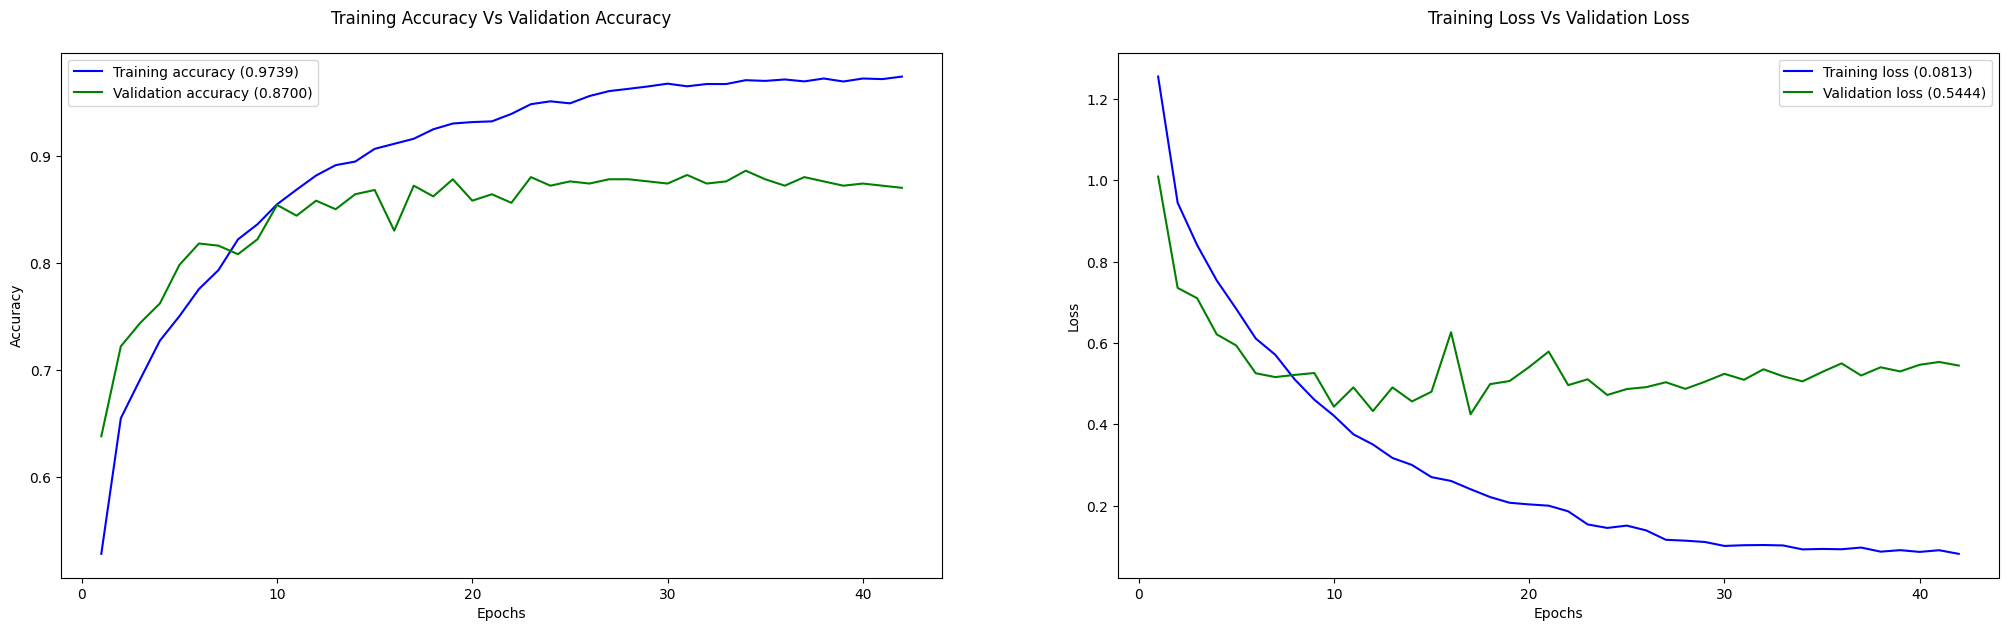

In [35]:
plot_history(history)

## Evaluate for test set

In [36]:
test_X = test_df["questions"]
test_y = test_df['label-coarse']

test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
X_test = pad_sequences(test_X, maxlen=maxlen, padding="post")
y_test = le.transform(test_y.values)

In [37]:
# Create a basic model instance
best_model = Model(inputs=inp, outputs=outp)

# load the weights
best_model.load_weights(checkpoint_filepath)
best_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Re-evaluate the model
last_test_loss, last_test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'Test Accuracy: {last_test_accuracy:.4f}')
print(f'Test Loss: {last_test_loss:.4f}')

# Evaluate best model
best_test_loss, best_test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f'Best Test Accuracy: {best_test_accuracy:.4f}')
print(f'Best Test Loss: {best_test_loss:.4f}')

16/16 [==============================] - 1s 60ms/step - loss: 0.2753 - accuracy: 0.9200
Test Accuracy: 0.9200
Test Loss: 0.2753
16/16 [==============================] - 6s 55ms/step - loss: 0.2753 - accuracy: 0.9200
Best Test Accuracy: 0.9200
Best Test Loss: 0.2753


16/16 [==============================] - 8s 50ms/step


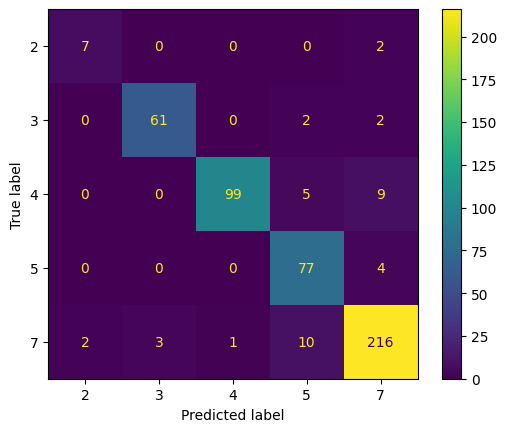

In [38]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

# y_best_pred = best_model.predict(X_test)
# cm_best = confusion_matrix(y_test, np.argmax(y_best_pred, axis=1))
# disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=le.classes_)
# disp_best.plot()